# End of Season Prediction

## 1. Introduction

This notebook contains a data science project predicting the Bundesliga league table at the end of the season using data from the first 18 matchday. A bivariate poisson model is used to predict match outcomes. Based on that a Monte Carlo simulation is run with `n=10.000` to estimate the probabilities of teams moving to certain positions in the table. 

To estimate `Lambda` for the poisson distribution: 
1. the average home and away goals will be used as an estimate. 
2. In the next step the home and away efficiency is calculated as the ratio of goals scored divided by chances created as well as goals conceded and chances allowed. Then `Lambda`  will be the estimated goals which will be defined as `chances created * attacking efficiency * defending effeciency`. 

At the end the two models will be compared to see if the more complex model will yield better results.

## 2. Data Preperation 

Before modelling we need to prepare the data to be in the correct format. We require data that we can derive the necessary stats from and additionally all the matches from the season. This two data sources have different characteristics. Therefore we need to make them compatible and usable for our model. 

In [558]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2.1 Load all matches of the season

First we load a table, that contains all the league matches with the columns `Round Number`, `Home Team`, `Away Team` and `Result`. The `Result` has the format `0 - 0`. This data is loaded from https://fixturedownload.com/results/bundesliga-2025. 

In [559]:
# load all matches from dataset
all_matches = pd.read_csv("../data/raw/Bundesliga-2025-UTC.csv")

# drop the columns Date, Location, Match Number
all_matches = all_matches.drop(columns=["Date", "Location", "Match Number"], axis=1)

all_matches.head()

,Round Number,Home Team,Away Team,Result
0,1,FC Bayern München,RB Leipzig,6 - 0
1,1,1. FC Heidenheim 1846,VfL Wolfsburg,1 - 3
2,1,1. FC Union Berlin,VfB Stuttgart,2 - 1
3,1,Sport-Club Freiburg,FC Augsburg,1 - 3
4,1,Eintracht Frankfurt,SV Werder Bremen,4 - 1


Further in our project we need to match the team names. Therefore we need to see the unique values for team names in the `all_matches` data. 

In [560]:
# show unique values of Home Team and Away Team in all matches and sort them alphabetically
team_names = all_matches["Home Team"].unique().tolist()
team_names.sort()
team_names

## 2.2 Load match statistics

After having loaded all matches of the season, we now load a table with all played matches with results and statistics.

The data is loaded from https://www.football-data.co.uk/germanym.php. This table contains a lot of data, but we will only use the following columns

Key to results data:

`Div = League Division`

`HomeTeam = Home Team`

`AwayTeam = Away Team`

`FTHG and HG = Full Time Home Team Goals`

`FTAG and AG = Full Time Away Team Goals`

`FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)`

`HS = Home Team Shots`

`AS = Away Team Shots`

`HST = Home Team Shots on Target`

`AST = Away Team Shots on Target`

In [561]:
# Load the dataset containing Bundesliga match data for the 2025 season
stats = pd.read_csv("../data/raw/Bundesliga_2025.csv")

# Display the first few rows of the dataset to understand its structure and contents
stats.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,D1,22/08/2025,19:30,Bayern Munich,RB Leipzig,6,0,H,3,0,...,1.98,1.88,1.98,1.93,1.99,1.93,1.90,1.86,2.07,1.92
1,D1,23/08/2025,14:30,Ein Frankfurt,Werder Bremen,4,1,H,2,0,...,1.83,2.03,2.02,1.91,1.91,2.03,1.83,1.93,1.91,2.06
2,D1,23/08/2025,14:30,Freiburg,Augsburg,1,3,A,0,3,...,1.93,1.93,1.97,1.95,1.97,1.93,1.90,1.86,2.03,1.96
3,D1,23/08/2025,14:30,Heidenheim,Wolfsburg,1,3,A,1,1,...,2.03,1.83,2.06,1.87,2.03,1.85,1.97,1.81,2.12,1.88
4,D1,23/08/2025,14:30,Leverkusen,Hoffenheim,1,2,A,1,1,...,1.98,1.88,1.97,1.95,1.98,2.02,1.88,1.86,2.00,1.97


In [562]:
# inspect dataset
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Columns: 131 entries, Div to BFECAHA
dtypes: float64(108), int64(16), object(7)
memory usage: 183.3+ KB


In [563]:
# print full list of columns
print(stats.columns.tolist())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BFDH', 'BFDD', 'BFDA', 'BMGMH', 'BMGMD', 'BMGMA', 'BVH', 'BVD', 'BVA', 'BWH', 'BWD', 'BWA', 'CLH', 'CLD', 'CLA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'BFEH', 'BFED', 'BFEA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'BFE>2.5', 'BFE<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'BFEAHH', 'BFEAHA', 'B365CH', 'B365CD', 'B365CA', 'BFDCH', 'BFDCD', 'BFDCA', 'BMGMCH', 'BMGMCD', 'BMGMCA', 'BVCH', 'BVCD', 'BVCA', 'BWCH', 'BWCD', 'BWCA', 'CLCH', 'CLCD', 'CLCA', 'LBCH', 'LBCD', 'LBCA', 'PSCH', 'PSCD', 'PSCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'BFECH', 'BFECD', 'BFECA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>

We reduce our DataFrame to only the columns that we will use during modelling. 

In [564]:
# reduce size of the dataset
stats = stats[
    ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "AS", "HST", "AST"]
]
stats.tail(20)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST
159,23/01/2026,St Pauli,Hamburg,0,0,D,8,5,3,2
160,24/01/2026,Bayern Munich,Augsburg,1,2,A,15,16,6,6
161,24/01/2026,Ein Frankfurt,Hoffenheim,1,3,A,9,10,3,5
162,24/01/2026,Heidenheim,RB Leipzig,0,3,A,7,11,2,8
163,24/01/2026,Leverkusen,Werder Bremen,1,0,H,13,17,4,3
164,24/01/2026,Mainz,Wolfsburg,3,1,H,20,7,9,2
165,24/01/2026,Union Berlin,Dortmund,0,3,A,10,15,3,5
166,25/01/2026,M'gladbach,Stuttgart,0,3,A,12,17,3,8
167,25/01/2026,Freiburg,FC Koln,2,1,H,13,19,5,4
168,27/01/2026,St Pauli,RB Leipzig,1,1,D,7,12,2,5


To have matching column names in our `stats` and `all_matches` DataFrame we nee to rename some columns.

In [565]:
# change the column names for HomeTeam to Home Team and AwayTeam to Away Team
stats = data.rename(columns={"HomeTeam": "Home Team", "AwayTeam": "Away Team"})
stats.head()

,Date,Home Team,Away Team,FTHG,FTAG,FTR,HS,AS,HST,AST
0,22/08/2025,FC Bayern München,RB Leipzig,6,0,H,19,12,10,1
1,23/08/2025,Eintracht Frankfurt,SV Werder Bremen,4,1,H,18,10,5,5
2,23/08/2025,Sport-Club Freiburg,FC Augsburg,1,3,A,16,14,4,5
3,23/08/2025,1. FC Heidenheim 1846,VfL Wolfsburg,1,3,A,7,15,2,5
4,23/08/2025,Bayer 04 Leverkusen,TSG Hoffenheim,1,2,A,7,10,2,5


In [566]:
# create a list of unique team names from HomeTeam in data and sort them alphabetically
team_names_stats = stats["Home Team"].unique().tolist()
team_names_stats.sort()
team_names_stats

The team names are different in the `matches` and `stats` DataFrame. We therefore need to do a matching. 

In [567]:
# match team names of data to fit that of all_matches for HomeTeam
stats["Home Team"] = stats["Home Team"].replace(
    {
        "Heidenheim": "1. FC Heidenheim 1846",
        "FC Koln": "1. FC Köln",
        "Union Berlin": "1. FC Union Berlin",
        "Mainz": "1. FSV Mainz 05",
        "Leverkusen": "Bayer 04 Leverkusen",
        "Dortmund": "Borussia Dortmund",
        "M'gladbach": "Borussia Mönchengladbach",
        "Ein Frankfurt": "Eintracht Frankfurt",
        "Augsburg": "FC Augsburg",
        "Bayern Munich": "FC Bayern München",
        "St Pauli": "FC St. Pauli",
        "Hamburg": "Hamburger SV",
        "RB Leipzig": "RB Leipzig",
        "Werder Bremen": "SV Werder Bremen",
        "Freiburg": "Sport-Club Freiburg",
        "Hoffenheim": "TSG Hoffenheim",
        "Stuttgart": "VfB Stuttgart",
        "Wolfsburg": "VfL Wolfsburg",
    }
)

In [568]:
# match team names of data to fit that of all_matches for AwayTeam
stats["Away Team"] = stats["Away Team"].replace(
    {
        "Heidenheim": "1. FC Heidenheim 1846",
        "FC Koln": "1. FC Köln",
        "Union Berlin": "1. FC Union Berlin",
        "Mainz": "1. FSV Mainz 05",
        "Leverkusen": "Bayer 04 Leverkusen",
        "Dortmund": "Borussia Dortmund",
        "M'gladbach": "Borussia Mönchengladbach",
        "Ein Frankfurt": "Eintracht Frankfurt",
        "Augsburg": "FC Augsburg",
        "Bayern Munich": "FC Bayern München",
        "St Pauli": "FC St. Pauli",
        "Hamburg": "Hamburger SV",
        "RB Leipzig": "RB Leipzig",
        "Werder Bremen": "SV Werder Bremen",
        "Freiburg": "Sport-Club Freiburg",
        "Hoffenheim": "TSG Hoffenheim",
        "Stuttgart": "VfB Stuttgart",
        "Wolfsburg": "VfL Wolfsburg",
    }
)

## 2.2 Team Statistics

We will now derive individual team statistics from the the match data for being the home or the away team. We will therefore calculate the average goals scored as home and away team, as well as the efficiency as home and away team. This will be the ratio of goals scored divided by chances created as well as goals conceded divided by chances allowed. 

In [569]:
# create home statistics
home_stats = stats.groupby("Home Team").agg(
    {"FTHG": "mean", "FTAG": "mean", "HS": "mean", "AS": "mean"}
)

home_stats.columns = [
    "avg_home_goals_scored",
    "avg_home_goals_conceded",
    "avg_home_shots_made",
    "avg_home_shots_conceded",
]

home_stats

In [570]:
# create away statistics
away_stats = stats.groupby("Away Team").agg(
    {"FTAG": "mean", "FTHG": "mean", "AS": "mean", "HS": "mean"}
)

away_stats.columns = [
    "avg_away_goals_scored",
    "avg_away_goals_conceded",
    "avg_away_shots_made",
    "avg_away_shots_conceded",
]

away_stats

In [571]:
# create measure of efficiency for home and away teams
home_stats["home_attack_eff"] = (
    home_stats["avg_home_goals_scored"] / home_stats["avg_home_shots_made"]
)

home_stats["home_defense_eff"] = (
    home_stats["avg_home_goals_conceded"] / home_stats["avg_home_shots_conceded"]
)

away_stats["away_attack_eff"] = (
    away_stats["avg_away_goals_scored"] / away_stats["avg_away_shots_made"]
)

away_stats["away_defense_eff"] = (
    away_stats["avg_away_goals_conceded"] / away_stats["avg_away_shots_conceded"]
)

In [572]:
# sort HomeTeams by home_scoring_efficiency
home_stats = home_stats.sort_values(by="home_attack_eff", ascending=False)

# sort AwayTeams by away_scoring_efficiency
away_stats = away_stats.sort_values(by="away_attack_eff", ascending=False)

In [573]:
home_stats

In [574]:
away_stats

### 2.2.1 Visualisations of Team Statistics

To understand the data better we create scatter plots of different stats.

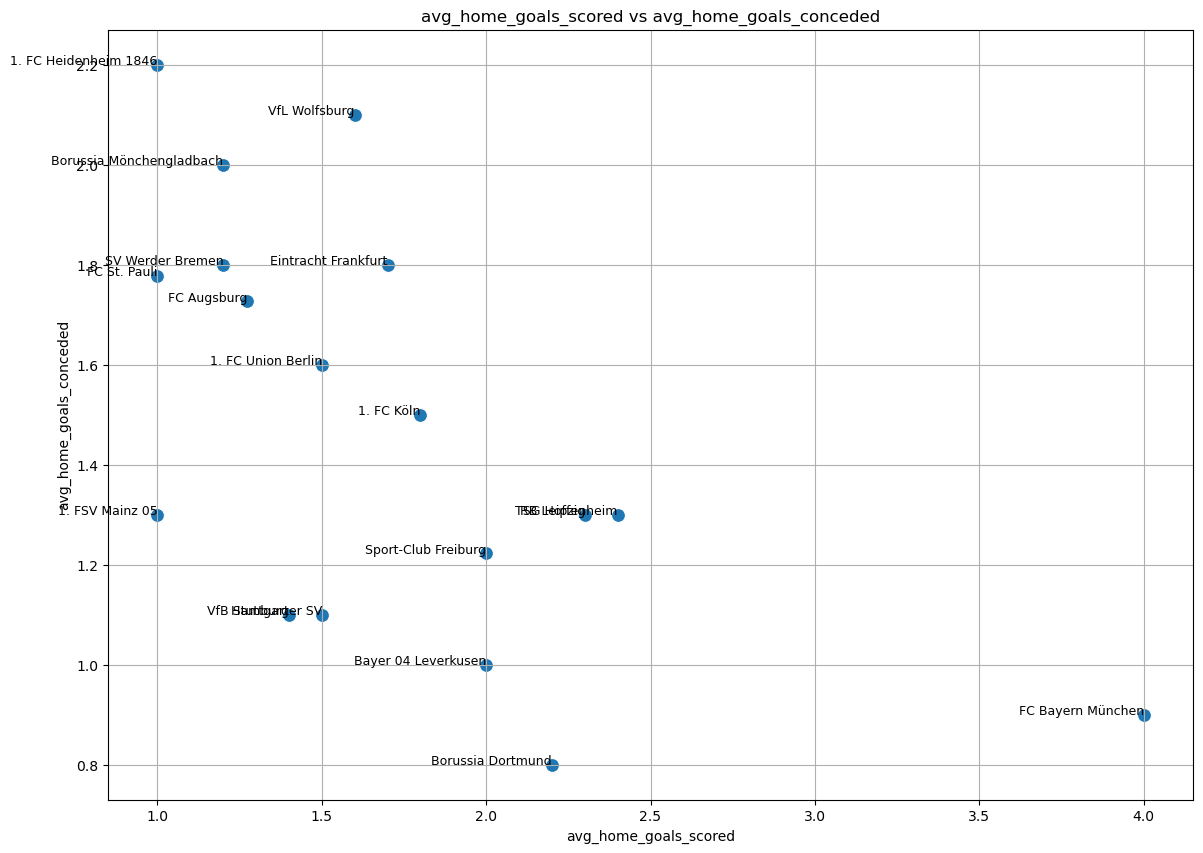

In [575]:
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=home_stats,
    x="avg_home_goals_scored",
    y="avg_home_goals_conceded",
    s=100,
)

# Annotate each point with the team name
for i in range(home_stats.shape[0]):
    plt.text(
        home_stats["avg_home_goals_scored"].iloc[i],
        home_stats["avg_home_goals_conceded"].iloc[i],
        home_stats.index[i],
        fontsize=9,
        ha="right",
    )

plt.title("avg_home_goals_scored vs avg_home_goals_conceded")
plt.xlabel("avg_home_goals_scored")
plt.ylabel("avg_home_goals_conceded")
plt.grid()
plt.show()

## 2.1 Create Current League Table

We create the current League Table after 18 matches (for some teams 17, as matches were delayed before of weather conditions) as a reference to later determine the probabilities of ending in a different position of the table. 

In [596]:
# create a function that calculates the league table based on the DataFrame stats
def calculate_league_table(matches):
    """
    Calculates the league table based on the given matches.

    Parameters:
    matches (DataFrame): A Pandas DataFrame containing match data.
                         Expected columns are "Home Team", "Away Team",
                         "Home Goals", "Away Goals", and "Result".

    Returns:
    DataFrame: A DataFrame representing the league table with teams,
                number of matches played, wins, draws, losses,
                goals for, goals against, goal difference, points, and position.
    """
    teams = matches["Home Team"].unique()
    league_table = pd.DataFrame(
        {
            "Team": teams,
            "Played": 0,
            "Wins": 0,
            "Draws": 0,
            "Losses": 0,
            "Goals For": 0,
            "Goals Against": 0,
            "Goal Difference": 0,
            "Points": 0,
        }
    )
    league_table.set_index("Team", inplace=True)

    for _, match in matches.iterrows():
        home_team = match["Home Team"]
        away_team = match["Away Team"]
        home_goals = match["Home Goals"]
        away_goals = match["Away Goals"]
        result = match["Result"]

        league_table.at[home_team, "Played"] += 1
        league_table.at[away_team, "Played"] += 1
        league_table.at[home_team, "Goals For"] += home_goals
        league_table.at[home_team, "Goals Against"] += away_goals
        league_table.at[away_team, "Goals For"] += away_goals
        league_table.at[away_team, "Goals Against"] += home_goals

        if result == "H":
            league_table.at[home_team, "Wins"] += 1
            league_table.at[away_team, "Losses"] += 1
            league_table.at[home_team, "Points"] += 3
        elif result == "A":
            league_table.at[away_team, "Wins"] += 1
            league_table.at[home_team, "Losses"] += 1
            league_table.at[away_team, "Points"] += 3
        else:
            league_table.at[home_team, "Draws"] += 1
            league_table.at[away_team, "Draws"] += 1
            league_table.at[home_team, "Points"] += 1
            league_table.at[away_team, "Points"] += 1

    league_table["Goal Difference"] = (
        league_table["Goals For"] - league_table["Goals Against"]
    )

    league_table = league_table.sort_values(
        by=["Points", "Goal Difference", "Goals For"], ascending=False
    )
    league_table["Position"] = range(1, len(league_table) + 1)

    return league_table.reset_index()

In [577]:
# calculate the league table based on played matches
league_table = calculate_league_table(stats)
league_table

,Team,Played,Wins,Draws,Losses,Goals For,Goals Against,Goal Difference,Points,Position
0,FC Bayern München,20,16,3,1,74,18,56,51,1
1,Borussia Dortmund,20,13,6,1,41,19,22,45,2
2,TSG Hoffenheim,20,13,3,4,43,23,20,42,3
3,VfB Stuttgart,20,12,3,5,37,26,11,39,4
4,RB Leipzig,20,11,3,6,38,27,11,36,5
5,Bayer 04 Leverkusen,19,11,2,6,38,26,12,35,6
6,Sport-Club Freiburg,20,7,6,7,31,33,-2,27,7
7,Eintracht Frankfurt,20,7,6,7,40,45,-5,27,8
8,1. FC Union Berlin,20,6,6,8,25,33,-8,24,9
9,1. FC Köln,20,6,5,9,29,32,-3,23,10


## 2.3 Remaining Matches

In [578]:
# only keep maches that have not yet been played and reset index
remaining_matches = all_matches[all_matches["Result"].isnull()].reset_index(drop=True)

# drop the round number column and the result column
remaining_matches = remaining_matches.drop(columns=["Round Number", "Result"], axis=1)

remaining_matches.head()

,Home Team,Away Team
0,Hamburger SV,Bayer 04 Leverkusen
1,1. FC Union Berlin,Eintracht Frankfurt
2,1. FC Heidenheim 1846,Hamburger SV
3,FC St. Pauli,VfB Stuttgart
4,VfL Wolfsburg,Borussia Dortmund


## 2.4 Played Matches

In [579]:
# creating the DataFrame played_matches that only contains the matches that have already been played from the stats DataFrame
played_matches = stats.copy()

# drop the Date, HS, AS, HST, AST columns
played_matches = played_matches.drop(columns=["Date", "HS", "AS", "HST", "AST"], axis=1)

# rename the FTHG column to Home Goals and FTAG to Away Goals and FTR to Result
played_matches = played_matches.rename(
    columns={"FTHG": "Home Goals", "FTAG": "Away Goals", "FTR": "Result"}
)

played_matches.head()

,Home Team,Away Team,Home Goals,Away Goals,Result
0,FC Bayern München,RB Leipzig,6,0,H
1,Eintracht Frankfurt,SV Werder Bremen,4,1,H
2,Sport-Club Freiburg,FC Augsburg,1,3,A
3,1. FC Heidenheim 1846,VfL Wolfsburg,1,3,A
4,Bayer 04 Leverkusen,TSG Hoffenheim,1,2,A


## 3 Poisson Model

We will model the goals by the home and away team indipendently from each other with a poisson model. 

## 3.1. Defining the Model

In [580]:
# defining a function to simulate a football match between two teams using their statistics and a poisson distribution
def simulate_match(home_team, away_team, home_stats, away_stats):
    """
    Simulates a football match between two teams based on their statistics.

    Parameters:
    home_team (str): The name of the home team.
    away_team (str): The name of the away team.
    home_stats (DataFrame): A DataFrame containing statistics for home teams.
    away_stats (DataFrame): A DataFrame containing statistics for away teams.

    Returns:
    tuple: A tuple containing the number of goals scored by the home team and the away team.
    """

    # Retrieve statistics for the home team
    home_team_stats = home_stats.loc[home_team]

    # Retrieve statistics for the away team
    away_team_stats = away_stats.loc[away_team]

    # Calculate efficiency metrics for the home team
    home_attack_eff = home_stats.loc[home_team, "home_attack_eff"]
    home_defense_eff = home_stats.loc[home_team, "home_defense_eff"]

    # Calculate efficiency metrics for the away team
    away_attack_eff = away_stats.loc[away_team, "away_attack_eff"]
    away_defense_eff = away_stats.loc[away_team, "away_defense_eff"]

    # Calculate expected goals for the home team
    expected_home_goals = (
        home_team_stats["avg_home_shots_made"]
        * home_attack_eff
        * (1 - away_defense_eff)
    )

    # Calculate expected goals for the away team
    expected_away_goals = (
        away_team_stats["avg_away_shots_made"]
        * away_attack_eff
        * (1 - home_defense_eff)
    )

    # Simulate the number of goals scored by the home team using a Poisson distribution
    home_goals = np.random.poisson(expected_home_goals)

    # Simulate the number of goals scored by the away team using a Poisson distribution
    away_goals = np.random.poisson(expected_away_goals)

    return home_goals, away_goals

In [581]:
# testing model for one match
home_team = "FC St. Pauli"
away_team = "RB Leipzig"

# Calculate efficiency metrics for the home team
home_attack_eff = home_stats.loc[home_team, "home_attack_eff"]
home_defense_eff = home_stats.loc[home_team, "home_defense_eff"]

# Calculate efficiency metrics for the away team
away_attack_eff = away_stats.loc[away_team, "away_attack_eff"]
away_defense_eff = away_stats.loc[away_team, "away_defense_eff"]

# simulate test match
simulate_match("FC St. Pauli", "RB Leipzig", home_stats, away_stats)

(0, 0)

## 3.2 Simulating Remaining Matches

In [582]:
# define a function to simulate the rest of the season
def simulate_season(remaining_matches, home_stats, away_stats):
    """
    Simulates the remaining matches of a football season.

    Parameters:
    remaining_matches (DataFrame): A DataFrame containing the remaining matches to be played.
    home_stats (DataFrame): A DataFrame containing statistics for home teams.
    away_stats (DataFrame): A DataFrame containing statistics for away teams.

    Returns:
    DataFrame: A DataFrame containing the results of the simulated matches.
    """

    # Create a copy of the remaining matches DataFrame to store results
    simulated_results = remaining_matches.copy()

    # Iterate through each match in the remaining matches
    for index, row in simulated_results.iterrows():
        home_team = row["Home Team"]  # Home team name
        away_team = row["Away Team"]  # Away team name

        # Simulate the match and get the number of goals scored by each team
        home_goals, away_goals = simulate_match(
            home_team, away_team, home_stats, away_stats
        )

        # Store the simulated results in the DataFrame
        simulated_results.at[index, "Home Goals"] = home_goals
        simulated_results.at[index, "Away Goals"] = away_goals

        # Determine the result of the match based on the number of goals scored
        if home_goals > away_goals:
            simulated_results.at[index, "Result"] = "H"  # Home team wins
        elif away_goals > home_goals:
            simulated_results.at[index, "Result"] = "A"  # Away team wins
        else:
            simulated_results.at[index, "Result"] = "D"  # Draw

    return simulated_results  # Return the DataFrame with simulated results

In [583]:
# simulate the rest of the season
simulated_season_results = simulate_season(remaining_matches, home_stats, away_stats)
simulated_season_results

,Home Team,Away Team,Home Goals,Away Goals,Result
0,Hamburger SV,Bayer 04 Leverkusen,1.0,1.0,D
1,1. FC Union Berlin,Eintracht Frankfurt,1.0,3.0,A
2,1. FC Heidenheim 1846,Hamburger SV,1.0,1.0,D
3,FC St. Pauli,VfB Stuttgart,2.0,2.0,D
4,VfL Wolfsburg,Borussia Dortmund,2.0,2.0,D
...,...,...,...,...,...
122,SV Werder Bremen,Borussia Dortmund,0.0,1.0,A
123,Sport-Club Freiburg,RB Leipzig,2.0,2.0,D
124,Eintracht Frankfurt,VfB Stuttgart,3.0,2.0,H
125,Bayer 04 Leverkusen,Hamburger SV,1.0,2.0,A


# 4. Monte Carlo Simulation

We will create a Monte Carlo Simulation with `N=1000` simulations of the rest of the season. 

In [591]:
# define a function to perform Monte Carlo simulation of the remaining matches
def monte_carlo_simulation(
    all_matches, played_matches, home_stats, away_stats, n_simulations=1000
):
    """
    Performs a Monte Carlo simulation of the remaining matches in a football season.

    Parameters:
    all_matches (DataFrame): A DataFrame containing all matches in the season.
    home_stats (DataFrame): A DataFrame containing statistics for home teams.
    away_stats (DataFrame): A DataFrame containing statistics for away teams.
    n_simulations (int): The number of simulations to run.

    Returns:
    list: A list of DataFrames containing the league tables from each simulation.
    """

    league_tables = []  # Initialize a list to store league tables from each simulation

    full_season_results_list = (
        []
    )  # Initialize a list to store full season results from each simulation

    # Perform the specified number of simulations
    for simulation_number in range(n_simulations):

        # Identify remaining matches that have not yet been played
        remaining_matches = all_matches[all_matches["Result"].isnull()].reset_index(
            drop=True
        )

        # drop the round number column and the result column
        remaining_matches = remaining_matches.drop(
            columns=["Round Number", "Result"], axis=1
        )

        # Simulate the remaining matches
        simulated_results = simulate_season(remaining_matches, home_stats, away_stats)

        # Combine simulated results with already played matches
        full_season_results = pd.concat(
            [played_matches, simulated_results], ignore_index=True
        )
        full_season_results_list.append(full_season_results)

        # Create the league table based on the full season results
        league_table = calculate_league_table(full_season_results)

        # Append the league table to the list
        league_tables.append(league_table)

    return (
        league_tables,
        full_season_results_list,
    )  # Return the list of league tables from simulations

In [599]:
# run monte carlo simulation with 1000 simulations
league_tables_simulations, full_season_results_simulations = monte_carlo_simulation(
    all_matches, played_matches, home_stats, away_stats, n_simulations=1000
)
# display first league table from simulations
league_tables_simulations[0]

# display first full season results from simulations
# full_season_results_simulations[0]

,Team,Played,Wins,Draws,Losses,Goals For,Goals Against,Goal Difference,Points,Position
0,FC Bayern München,34,26,3,5,113,41,72,81,1
1,TSG Hoffenheim,34,22,6,6,74,40,34,72,2
2,Borussia Dortmund,34,21,8,5,66,40,26,71,3
3,VfB Stuttgart,34,19,8,7,58,42,16,65,4
4,RB Leipzig,34,18,6,10,63,42,21,60,5
5,Bayer 04 Leverkusen,34,18,5,11,74,46,28,59,6
6,Eintracht Frankfurt,34,16,9,9,58,53,5,57,7
7,Sport-Club Freiburg,34,13,8,13,47,51,-4,47,8
8,1. FC Union Berlin,34,12,9,13,46,60,-14,45,9
9,1. FC Köln,34,9,13,12,49,50,-1,40,10


# 5 Visualisation of Monte Carlo Results

In [605]:
# create a DataFrame to store the final positions of each team across all simulations
final_positions = pd.DataFrame(0, index=team_names, columns=range(1, 19))
# populate the final_positions DataFrame containing the count of final positions for each team
for league_table in league_tables_simulations:
    for _, row in league_table.iterrows():
        team = row["Team"]
        position = row["Position"]
        final_positions.at[team, position] += 1

# normalize the final_positions DataFrame to get probabilities
final_positions = final_positions.div(final_positions.sum(axis=1), axis=0)

# change the order so that each team is in the row of its current position in the league table
current_league_table = calculate_league_table(played_matches)
final_positions = final_positions.reindex(current_league_table["Team"])

# display final positions DataFrame
final_positions

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Team,,,,,,,,,,,,,,,,,,
FC Bayern München,0.986,0.014,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Borussia Dortmund,0.012,0.466,0.260,0.143,0.076,0.035,0.007,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
TSG Hoffenheim,0.002,0.344,0.314,0.193,0.101,0.038,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
VfB Stuttgart,0.000,0.066,0.182,0.236,0.248,0.211,0.051,0.004,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
RB Leipzig,0.000,0.037,0.084,0.180,0.248,0.295,0.126,0.024,0.005,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Bayer 04 Leverkusen,0.000,0.071,0.156,0.234,0.254,0.213,0.057,0.014,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Sport-Club Freiburg,0.000,0.000,0.003,0.001,0.008,0.045,0.209,0.415,0.181,0.087,0.027,0.016,0.003,0.003,0.002,0.000,0.000,0.000
Eintracht Frankfurt,0.000,0.002,0.001,0.013,0.064,0.159,0.479,0.201,0.049,0.022,0.007,0.002,0.001,0.000,0.000,0.000,0.000,0.000
1. FC Union Berlin,0.000,0.000,0.000,0.000,0.000,0.001,0.025,0.110,0.218,0.201,0.156,0.110,0.075,0.051,0.034,0.013,0.006,0.000


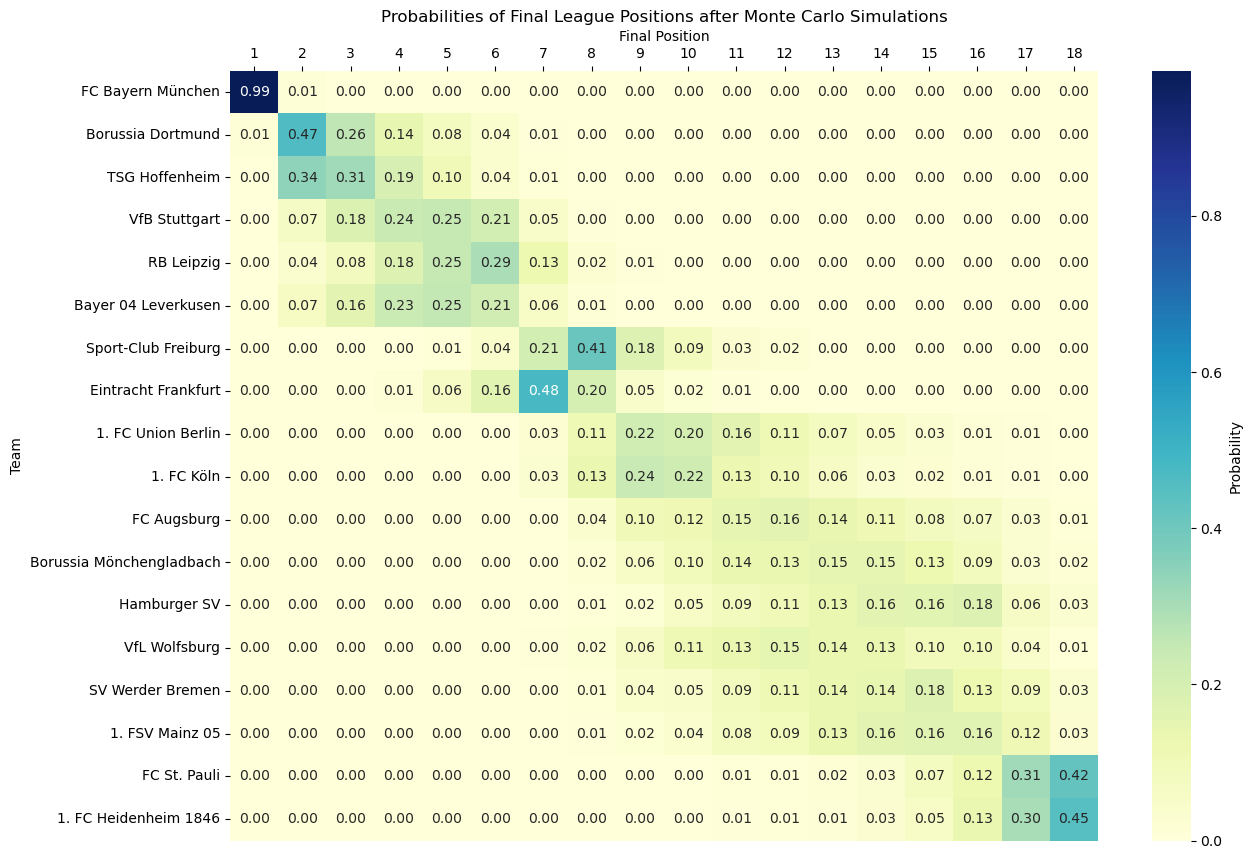

In [610]:
# create a heatmap to visualize the probabilities of each team finishing in each position
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    final_positions,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Probability"},
)

plt.title("Probabilities of Final League Positions after Monte Carlo Simulations")
plt.xlabel("Final Position")
plt.ylabel("Team")
plt.yticks(rotation=0)

# X-Achsen-Werte nach oben verschieben
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

plt.show()